In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import shutil
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
import multiprocessing
import sys
#from google.colab import drive
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")
nltk.download('punkt')
chachedWords = stopwords.words('english')
import matplotlib.pyplot as plt
import string
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import json
from collections import Counter
from multiprocessing import Pool
from tqdm.auto import tqdm
from transformers import BertForSequenceClassification, AdamW, BertConfig, AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

%matplotlib inline
#drive.mount('/content/gdrive/')

#root_folder = "/content/gdrive/MyDrive/Colab Notebooks/CS182-Spring2020-NLP-Project"
#sys.path.append(root_folder)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/letantruong32/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/letantruong32/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**1. Access** **The Data:**

In [4]:
ls

Untitled.ipynb  data.ipynb    sample_eval.jsonl
__pycache__/    nltk_data/    test_submission.py
config.py       output.jsonl  yelp_review_training_dataset.jsonl


In [5]:
cd gdrive

[Errno 2] No such file or directory: 'gdrive'
/home/letantruong32


In [6]:
cd MyDrive

[Errno 2] No such file or directory: 'MyDrive'
/home/letantruong32


In [7]:
cd Colab Notebooks

[Errno 2] No such file or directory: 'Colab Notebooks'
/home/letantruong32


In [8]:
cd CS182-Spring2020-NLP-Project

[Errno 2] No such file or directory: 'CS182-Spring2020-NLP-Project'
/home/letantruong32


In [5]:
import config
#import test_submission
data = pd.read_json('yelp_review_training_dataset.jsonl', lines=True, orient='columns', encoding='utf-8')
data = data.drop(columns=['review_id'])
data

,text,stars
0,Total bill for this horrible service? Over $8G...,1
1,I *adore* Travis at the Hard Rock's new Kelly ...,5
2,I have to say that this office really has it t...,5
3,Went in for a lunch. Steak sandwich was delici...,5
4,Today was my second out of three sessions I ha...,1
...,...,...
533576,Dr Young and her assistants take obvious pride...,5
533577,We started our 20 month of daughter here on an...,5
533578,"First of all, they are supposed to open at 9:0...",2
533579,It's not often that you visit a company and th...,5


**2. Experiment The Data**

In [6]:
chachedWords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

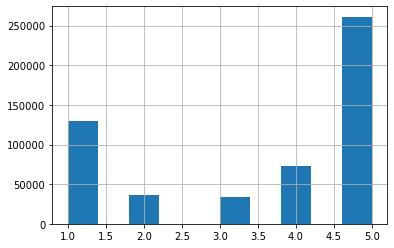

In [7]:
stars_his = data['stars'].hist()

# Data Augmentation

In [8]:
counter_star = Counter(data['stars'])
counter_star

Counter({1: 129878, 5: 261160, 4: 72422, 3: 34263, 2: 35858})

In [9]:
min_class = -1
min_amount = 1000000000
for cs in counter_star:
    if min_amount > counter_star[cs]:
        min_amount = counter_star[cs]
        min_class = cs
min_class, min_amount

(3, 34263)

In [10]:
remove_amounts = {c: abs(min_amount - counter_star[c]) for c in counter_star}
remove_amounts[1] -= 1
remove_amounts

{1: 95614, 5: 226897, 4: 38159, 3: 0, 2: 1595}

In [11]:
drop_indices = []
for index, row in data.iterrows():
    if remove_amounts[row['stars']] > 0:
        remove_amounts[row['stars']] -= 1
        drop_indices.append(index)
len(drop_indices)

362265

<AxesSubplot:>

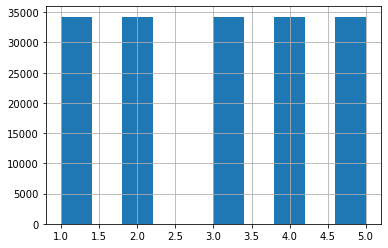

In [12]:
balanced_data = data.drop(drop_indices)
balanced_data['stars'].hist()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='stars', ylabel='count'>

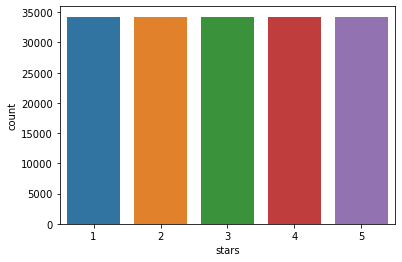

In [13]:
sns.countplot(balanced_data['stars'])

In [14]:
def text_clean(message):
    nopunc = [i for i in message if i not in string.punctuation]
    nn = "".join(nopunc)
    nn = nn.lower().split()
    nostop = [w for w in nn if w not in chachedWords]
    return(nostop)

In [15]:
x = balanced_data['text'].apply(text_clean)
print(x[:100])

6      [tracy, dessert, big, name, hong, kong, one, f...
9      [giant, best, buy, 66, registers, dont, get, w...
17     [love, chinese, food, love, mexican, food, go,...
19     [good, selection, classes, beers, mains, ive, ...
40     [one, day, satisfy, frozen, yogurt, craving, k...
                             ...                        
912    [first, time, ordering, wings, really, good, a...
914    [since, everyone, family, digs, tandoori, time...
915    [meal, decent, ordered, chicken, souvlaki, chi...
918    [reason, theyre, getting, 3, stars, food, grea...
919    [art, steel, eclectic, collection, glass, stee...
Name: text, Length: 100, dtype: object


In [16]:
y = balanced_data['stars']
y

6         3
9         3
17        3
19        3
40        3
         ..
533576    5
533577    5
533578    2
533579    5
533580    5
Name: stars, Length: 171316, dtype: int64

In [17]:
# ref: https://towardsdatascience.com/sentiment-analysis-using-lstm-step-by-step-50d074f09948
all_words = [w for m in x for w in m ]
print(all_words[:100])


['tracy', 'dessert', 'big', 'name', 'hong', 'kong', 'one', 'first', 'markham', 'place', 'many', 'years', 'came', 'chinese', 'dessert', 'must', 'say', 'selection', 'increased', 'tremendously', 'years', 'might', 'well', 'add', 'price', 'also', 'increased', 'tremendously', 'well', 'waitress', 'gave', 'us', 'tea', 'could', 'taste', 'red', 'date', 'fancy', 'simple', 'taro', 'coconut', 'tapioca', 'pearls', 'like', '525', 'something', 'basically', 'desserts', '5', 'thats', 'crazy', 'literally', 'make', 'dessert', 'home', 'bowl', 'would', 'probably', 'cost', 'like', '050', 'years', 'ago', 'think', 'still', 'get', 'like', '34', 'reasonable', 'wow', '5', 'little', 'top', 'dessert', 'though', 'must', 'say', 'tracy', 'dessert', 'little', 'expensive', 'side', 'also', 'saw', 'items', 'menu', 'like', 'fish', 'balls', 'chicken', 'wings', 'shaved', 'ice', 'friend', 'got', 'mango', 'drink', 'fresh', 'mango', 'im']


In [18]:
count_words = Counter(all_words)
sorted_words = count_words.most_common(len(all_words))
print(sorted_words)

[('good', 70182), ('place', 68814), ('would', 62835), ('time', 60709), ('food', 60032), ('get', 59785), ('like', 58133), ('one', 57544), ('service', 56544), ('great', 52948), ('back', 51443), ('go', 43602), ('really', 37938), ('dont', 37539), ('even', 34437), ('also', 32887), ('got', 31983), ('didnt', 31706), ('us', 30336), ('nice', 29578), ('im', 29058), ('never', 28948), ('staff', 28639), ('said', 28274), ('went', 28052), ('could', 27628), ('well', 26885), ('first', 25940), ('told', 25542), ('people', 25431), ('ive', 24898), ('came', 24268), ('always', 23344), ('order', 23339), ('much', 23324), ('going', 23003), ('work', 22447), ('know', 22391), ('day', 22323), ('new', 21999), ('friendly', 21911), ('make', 21665), ('store', 21637), ('come', 21615), ('little', 21372), ('two', 20931), ('experience', 20883), ('ordered', 20296), ('2', 20198), ('better', 20177), ('way', 20069), ('made', 19717), ('customer', 19555), ('asked', 19523), ('best', 19368), ('take', 19022), ('still', 18781), ('pr

In [19]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}
vocab_to_int['good'], vocab_to_int['bad'], vocab_to_int['however']

(1, 72, 115)

In [20]:
reviews_int = []
for review in x:
  review_int = []
  for w in review:
    review_int.append(vocab_to_int[w])
  reviews_int.append(review_int)
print(vocab_to_int['tracy'], reviews_int[0])
print(len(reviews_int))

7193 [7193, 670, 162, 311, 5284, 5437, 8, 28, 4079, 2, 98, 102, 32, 537, 670, 428, 70, 190, 3733, 7267, 102, 380, 27, 610, 66, 16, 3733, 7267, 27, 385, 149, 19, 395, 26, 211, 564, 688, 1279, 539, 4840, 1871, 4381, 7922, 7, 10467, 100, 689, 1533, 112, 143, 1008, 559, 42, 670, 84, 697, 3, 200, 354, 7, 10564, 102, 308, 83, 57, 6, 7, 2149, 429, 907, 112, 45, 250, 670, 103, 428, 70, 7193, 670, 45, 353, 165, 16, 334, 197, 116, 7, 398, 1933, 67, 465, 3483, 382, 279, 17, 1630, 236, 147, 1630, 21, 16, 624, 98, 30, 44, 7193, 670, 37, 32, 713, 394, 33, 820, 83, 409, 394, 375, 8, 13, 332, 1189, 110, 4, 394, 403, 933, 185, 783]
171316


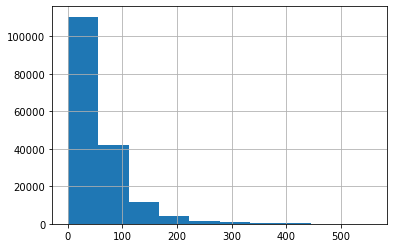

count    171316.000000
mean         56.864163
std          52.630064
min           0.000000
25%          23.000000
50%          41.000000
75%          71.000000
max         557.000000
dtype: float64

In [21]:
pd.Series([len(x) for x in reviews_int]).hist()
plt.show()
pd.Series([len(x) for x in reviews_int]).describe()

# TRAINING USING LSTM

In [26]:
def pad_features(reviews_int, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype = int)
    
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features

In [27]:
pad_reviews_int = pad_features(reviews_int, 300)

In [28]:
pad_reviews_int

array([[   0,    0,    0, ...,  933,  185,  783],
       [   0,    0,    0, ...,  162,  275,    2],
       [   0,    0,    0, ...,   92,   91,   39],
       ...,
       [   0,    0,    0, ..., 4807, 3578, 2240],
       [   0,    0,    0, ..., 1417,  462,  782],
       [   0,    0,    0, ..., 3438,   81,  131]])

In [31]:
from sklearn.model_selection import train_test_split
y = y.to_numpy()
train_x, x_remain, train_y, y_remain = train_test_split(pad_reviews_int, y, test_size = 0.2)
valid_x = x_remain[0:int(len(x_remain)*0.5)]
valid_y = y_remain[0:int(len(y_remain)*0.5)]
test_x = x_remain[int(len(x_remain)*0.5):]
test_y = y_remain[int(len(y_remain)*0.5):]
print(train_x, train_y)

[[   0    0    0 ... 5842  615   20]
 [   0    0    0 ...    3 2764  970]
 [   0    0    0 ...   61 3487 3487]
 ...
 [   0    0    0 ... 1074  108  957]
 [   0    0    0 ...  217   12   11]
 [   0    0    0 ...   14   59  161]] [5 1 3 ... 4 1 4]


In [32]:
from torch.utils.data import DataLoader, TensorDataset
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
# dataloaders
batch_size = 50
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [33]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 300])
Sample input: 
 tensor([[   0,    0,    0,  ...,   57, 2063, 3250],
        [   0,    0,    0,  ...,  100,   36, 7713],
        [   0,    0,    0,  ..., 5080,  568, 2893],
        ...,
        [   0,    0,    0,  ..., 7662,  238, 4079],
        [   0,    0,    0,  ..., 6244,  398,  198],
        [   0,    0,    0,  ...,  796, 3028, 2321]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([4, 2, 4, 2, 3, 3, 5, 5, 3, 2, 1, 3, 2, 1, 5, 3, 3, 4, 2, 5, 3, 3, 4, 2,
        3, 1, 3, 1, 1, 1, 1, 3, 3, 4, 3, 1, 3, 4, 3, 1, 2, 2, 3, 3, 5, 4, 1, 3,
        2, 5])


In [34]:
import torch.nn as nn

class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if torch.cuda.is_available():
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [35]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2
net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

SentimentLSTM(
  (embedding): Embedding(169047, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


# training params

epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5 # gradient clipping

# move model to GPU, if available
train_on_gpu = torch.cuda.is_available()
device = torch.device("cuda" if train_on_gpu else "cpu")
net = net.to(device)

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        inputs = inputs.type(torch.LongTensor)
        inputs = inputs.to(device)
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if train_on_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()

                inputs = inputs.type(torch.LongTensor)
                inputs = inputs.to(device)
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/4... Step: 100... Loss: -188.000000... Val Loss: -200.397661
Epoch: 1/4... Step: 200... Loss: -240.000000... Val Loss: -200.345029
Epoch: 1/4... Step: 300... Loss: -172.000000... Val Loss: -200.450292
Epoch: 1/4... Step: 400... Loss: -210.000000... Val Loss: -200.438596
Epoch: 1/4... Step: 500... Loss: -192.000000... Val Loss: -200.426901
Epoch: 1/4... Step: 600... Loss: -200.000000... Val Loss: -200.362573
Epoch: 1/4... Step: 700... Loss: -168.000000... Val Loss: -200.415205
Epoch: 1/4... Step: 800... Loss: -216.000000... Val Loss: -200.409357
Epoch: 1/4... Step: 900... Loss: -190.000000... Val Loss: -200.444444
Epoch: 1/4... Step: 1000... Loss: -202.000000... Val Loss: -200.491228
Epoch: 1/4... Step: 1100... Loss: -218.000000... Val Loss: -200.415205
Epoch: 1/4... Step: 1200... Loss: -172.000000... Val Loss: -200.444444
Epoch: 1/4... Step: 1300... Loss: -196.000000... Val Loss: -200.368421
Epoch: 1/4... Step: 1400... Loss: -216.000000... Val Loss: -200.385965
Epoch: 1/4... S

In [ ]:
test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    inputs = inputs.type(torch.LongTensor)
    inputs = inputs.to(device)
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

# TRAINING OUR DATA USING NAIVE BAYES

In [16]:
balanced_data

,text,stars
6,Tracy dessert had a big name in Hong Kong and ...,3
9,It's a giant Best Buy with 66 registers. I do...,3
17,I love chinese food and I love mexican food. W...,3
19,Good selection of classes of beers and mains. ...,3
40,One day after I satisfy my frozen yogurt cravi...,3
...,...,...
533576,Dr Young and her assistants take obvious pride...,5
533577,We started our 20 month of daughter here on an...,5
533578,"First of all, they are supposed to open at 9:0...",2
533579,It's not often that you visit a company and th...,5


In [23]:
x = balanced_data['stars']
y = balanced_data['text']


In [22]:
y.iloc[0]

"Tracy dessert had a big name in Hong Kong and the one in First Markham place has been here for many years now! \n\nCame in for some Chinese dessert, and I must say their selection has increased tremendously over the years. I might as well add that the price has also increased tremendously as well. The waitress gave us tea, which I could taste had red date in it. Fancy!\n\nA simple taro with coconut with tapioca pearls was like $5.25 or something. Basically all the desserts were more than $5. That's crazy! I can literally just make this dessert at home and for a bowl, it would probably cost like $0.50. A few years ago, I think I can still get it for like $3-$4, which is more reasonable, but wow, more than $5 is a little over the top for this dessert. Though I must say, it is Tracy Dessert, and they are a little more on the expensive side. \n\nI also saw other items on the menu like fish balls, chicken wings, shaved ice. My friend got a mango drink with fresh mango in it! \n\nI'm also s

In [24]:
review = y.iloc[0]
nltk.word_tokenize(review)

['Tracy',
 'dessert',
 'had',
 'a',
 'big',
 'name',
 'in',
 'Hong',
 'Kong',
 'and',
 'the',
 'one',
 'in',
 'First',
 'Markham',
 'place',
 'has',
 'been',
 'here',
 'for',
 'many',
 'years',
 'now',
 '!',
 'Came',
 'in',
 'for',
 'some',
 'Chinese',
 'dessert',
 ',',
 'and',
 'I',
 'must',
 'say',
 'their',
 'selection',
 'has',
 'increased',
 'tremendously',
 'over',
 'the',
 'years',
 '.',
 'I',
 'might',
 'as',
 'well',
 'add',
 'that',
 'the',
 'price',
 'has',
 'also',
 'increased',
 'tremendously',
 'as',
 'well',
 '.',
 'The',
 'waitress',
 'gave',
 'us',
 'tea',
 ',',
 'which',
 'I',
 'could',
 'taste',
 'had',
 'red',
 'date',
 'in',
 'it',
 '.',
 'Fancy',
 '!',
 'A',
 'simple',
 'taro',
 'with',
 'coconut',
 'with',
 'tapioca',
 'pearls',
 'was',
 'like',
 '$',
 '5.25',
 'or',
 'something',
 '.',
 'Basically',
 'all',
 'the',
 'desserts',
 'were',
 'more',
 'than',
 '$',
 '5',
 '.',
 'That',
 "'s",
 'crazy',
 '!',
 'I',
 'can',
 'literally',
 'just',
 'make',
 'this',
 'de

**Length of Reviews:**

<AxesSubplot:>

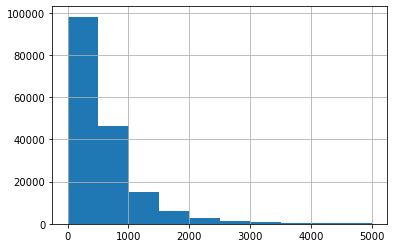

In [25]:
balanced_data['text'].str.len().hist()

In [26]:
balanced_data.loc[ data['text'].str.len() == balanced_data['text'].str.len().max() ]                                                  
#THE LONGER THE LENGTH, THE WORSE THE STAR IS

,text,stars
363409,We have been looking to get a new roof for abo...,2
366620,WHO THE F*** USES YELP IN 2017?\n\nTL;DR - thi...,3
378518,Intro - I saw an ad for new homes from Andrin ...,4
434126,Lawrence Ennis is the most disrespectful perso...,1
443144,be veryyyyy cautious about bringing your car h...,1
445623,I had heard so many wonderful reviews about Sa...,1
449049,I was at Rush Hour Grille on 10/14/2017 for th...,2
481629,"As a preface, I'll point out that even though ...",2
514786,Do you know www.lowes.ca/ reviews your reviews...,1
520251,"I got married recently (September, 2013) at th...",2


**As the goal and robustness of our model is the AVERAGE DISTANCE (in number of stars) between our predictions and true ratings. We can classify our star types into 3 groups.**

In [27]:
CustExp = []
for s in balanced_data['stars']:
  if s == 1:
    CustExp.append('TERRIBLE')
  elif s == 2 or s == 3:
    CustExp.append('NEUTRAL')
  else:
    CustExp.append('EXCELLENT')

In [28]:
balanced_data['CustomerExp'] = CustExp
balanced_data['CustomerExp'].value_counts()

EXCELLENT    68526
NEUTRAL      68526
TERRIBLE     34264
Name: CustomerExp, dtype: int64

In [29]:
#data['Text Length'] = data['text'].apply(lambda x : len(nltk.word_tokenize(x)))
#data.head()

In [30]:
balanced_data['Text Length'] = balanced_data['text'].apply(lambda x : len(x.split()))

In [31]:
balanced_data.loc[balanced_data['text'].str.len() == balanced_data['text'].str.len().max() ] 

,text,stars,CustomerExp,Text Length
363409,We have been looking to get a new roof for abo...,2,NEUTRAL,946
366620,WHO THE F*** USES YELP IN 2017?\n\nTL;DR - thi...,3,NEUTRAL,871
378518,Intro - I saw an ad for new homes from Andrin ...,4,EXCELLENT,963
434126,Lawrence Ennis is the most disrespectful perso...,1,TERRIBLE,1019
443144,be veryyyyy cautious about bringing your car h...,1,TERRIBLE,984
445623,I had heard so many wonderful reviews about Sa...,1,TERRIBLE,992
449049,I was at Rush Hour Grille on 10/14/2017 for th...,2,NEUTRAL,959
481629,"As a preface, I'll point out that even though ...",2,NEUTRAL,900
514786,Do you know www.lowes.ca/ reviews your reviews...,1,TERRIBLE,911
520251,"I got married recently (September, 2013) at th...",2,NEUTRAL,918


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='stars', ylabel='count'>

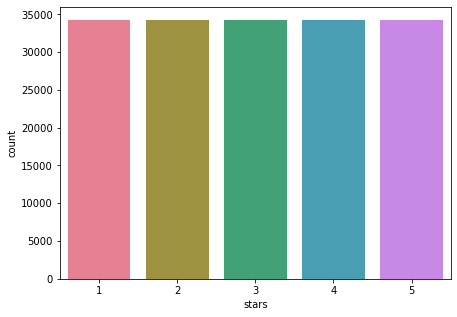

In [32]:
plt.figure(figsize = (7,5))
sns.countplot('stars', data = balanced_data, palette="husl")

In [33]:
def text_remove_puncs(text):
    text = text.lower()
    p = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    text = ''.join([ch for ch in text if ch not in p])
    return text.split()

In [34]:
excellent = balanced_data[balanced_data['CustomerExp'] == 'EXCELLENT']
excellent_words_list = text_clean(excellent['text'])
excellent_para = ' '.join(excellent_words_list)

horrible = balanced_data[balanced_data['CustomerExp'] == 'HORRIBLE']
horrible_words_list = text_clean(horrible['text'])
horrible_para = ' '.join(horrible_words_list)

neutral = balanced_data[balanced_data['CustomerExp'] == 'NEUTRAL']
neutral_words_list = text_clean(neutral['text'])
neutral_para = ' '.join(neutral_words_list)

In [35]:
cv_transformer = CountVectorizer(analyzer = text_clean)

In [36]:
x = balanced_data['text']
y = balanced_data['CustomerExp']
x = cv_transformer.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 101)


In [37]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(x_train, y_train)

y_pred = nb.predict(x_test)
y_pred

array(['NEUTRAL', 'EXCELLENT', 'TERRIBLE', ..., 'EXCELLENT', 'TERRIBLE',
       'EXCELLENT'], dtype='<U9')

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[10401  2475   893]
 [ 1860  9190  2688]
 [   98  1732  4927]]


              precision    recall  f1-score   support

   EXCELLENT       0.84      0.76      0.80     13769
     NEUTRAL       0.69      0.67      0.68     13738
    TERRIBLE       0.58      0.73      0.65      6757

    accuracy                           0.72     34264
   macro avg       0.70      0.72      0.71     34264
weighted avg       0.73      0.72      0.72     34264



**USING x=text; y=stars**

In [39]:
from sklearn.metrics import mean_absolute_error
x = balanced_data['text']
y = balanced_data['stars']
x = cv_transformer.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 101)

nb = MultinomialNB()
nb.fit(x_train, y_train)




MultinomialNB()

In [40]:
y_pred = nb.predict(x_test)
y_pred

array([3, 5, 1, ..., 5, 1, 5])

In [41]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[4914 1254  466   57   66]
 [1982 2283 2274  281  140]
 [ 687 1158 3124 1511  298]
 [ 307  361 1355 3607 1168]
 [ 390  110  187 1870 4414]]


              precision    recall  f1-score   support

           1       0.59      0.73      0.65      6757
           2       0.44      0.33      0.38      6960
           3       0.42      0.46      0.44      6778
           4       0.49      0.53      0.51      6798
           5       0.73      0.63      0.68      6971

    accuracy                           0.54     34264
   macro avg       0.53      0.54      0.53     34264
weighted avg       0.54      0.54      0.53     34264



In [42]:
mean_absolute_error(y_test, y_pred)

0.6069927620826523

# TRAINING USING BERT

In [22]:
balanced_data['stars'] = balanced_data['stars'] - 1

In [23]:
NUM_CLASSES = len(balanced_data['stars'].unique())

In [24]:
tokenizer = AutoTokenizer.from_pretrained(config.PRE_TRAINED_MODEL_NAME)

In [25]:
def parallelize_dataframe(df, func, n_cores=8):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [26]:
def count_tokens(df):
    df['text_len'] = df['text'].apply(lambda t : len(tokenizer.encode(t, max_length=config.MAX_LENGTH)))
    return df

In [27]:
%%time

balanced_simplified_reviews = parallelize_dataframe(balanced_data, count_tokens, 10)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

CPU times: user 370 ms, sys: 646 ms, total: 1.02 s
Wall time: 17.8 s


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='text_len', ylabel='Density'>

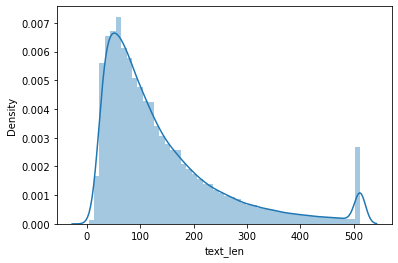

In [28]:
sns.distplot(balanced_simplified_reviews['text_len'])

In [29]:
class YelpDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews, self.targets,  self.tokenizer, self.max_len = reviews.to_numpy(), targets.to_numpy(), tokenizer, max_len
        
    def __len__(self):
        return len(self.reviews)
        
    def __getitem__(self, item):
        review = self.reviews[item]
        tokens = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'review': review,
            'input_ids': tokens['input_ids'].flatten(),
            'attention_mask': tokens['attention_mask'].flatten(),
            'target': torch.tensor(self.targets[item]).long()
        }

In [30]:
RANDOM_SEED = 32

def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

In [31]:
train_df, test_df = train_test_split(balanced_simplified_reviews, test_size=0.1, random_state=RANDOM_SEED, 
                                     stratify=balanced_simplified_reviews.stars.values)
valid_df, test_df = train_test_split(test_df, test_size=0.5, random_state=RANDOM_SEED, stratify=test_df.stars.values)
train_df.shape, test_df.shape, valid_df.shape

((154184, 3), (8566, 3), (8566, 3))

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='stars', ylabel='count'>

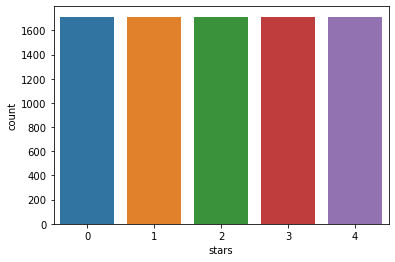

In [32]:
sns.countplot(valid_df['stars'])


In [33]:
def create_data_loader(df, tokenizer, max_length, batch_size):
    ds = YelpDataset(df['text'], df['stars'], tokenizer, max_length)
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=multiprocessing.cpu_count() - 1
    )

In [34]:
BATCH_SIZE=8

train_dl = create_data_loader(train_df, tokenizer, config.MAX_LENGTH, BATCH_SIZE)
test_dl = create_data_loader(test_df, tokenizer, config.MAX_LENGTH, BATCH_SIZE)
valid_dl = create_data_loader(valid_df, tokenizer, config.MAX_LENGTH, BATCH_SIZE)

In [35]:
sample_record = next(iter(train_dl))
sample_record['input_ids'][0]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

tensor([  101,  2119, 16839,  1121,  1103,  3761,  1177,  1677,   117,  1128,
          112,  1231,  1719,  6100,   181,  1358,  1964,  1142,  1282,  1137,
         4819,  1122,   119,   146,  2141,  1107,  1314,  1480,  1105,  7315,
         4830,  1146,  1106,  1103,  2927,   119,   146,  1108, 11196, 20710,
         1193,  1118,  6936,  1103, 18343,  1150,  1400,  1143,  1103,  1211,
         5426,  1645,  1152,  1138,  1113, 12999,   117,   170, 14286, 11153,
          117,  1105, 21568,  1143,  1115,  9031,  6823,  1132, 13473,  1480,
          119,  1370,   109,   126,   119,  3135,  1128,  1169,  1243,   170,
         1995,  4305, 13473,  1114,  1160, 27001,  1116,   119,  1966,  1115,
         4234,  1176,   170,  2239,  1106,  1143,   117,   146,  1198,  1445,
          112,   189,  1107,  1103,  6601,  1111, 13473,  1105, 12243,  1106,
         1546,  1121,  1103, 13171,  1939,   119,  1135,  1261,   170,  1229,
         1111,  1143,  1106,  4142,  1205,  1184,   146,  1458, 

In [36]:
sample_record['attention_mask'][0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [38]:
model = BertForSequenceClassification.from_pretrained(config.PRE_TRAINED_MODEL_NAME, num_labels = NUM_CLASSES, 
                                                      output_attentions = False, output_hidden_states = False)
model = model.to(device)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [39]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-3},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [40]:
len([p for n, p in param_optimizer if not any(nd in n for nd in no_decay)]), len([p for n, p in param_optimizer if any(nd in n for nd in no_decay)])


(77, 124)

In [41]:
# AdamW Adam algorithm with weight decay fix
optimizer = AdamW(optimizer_parameters, 
                  lr = 2e-5, # args.learning_rate - default is 5e-5,
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                 )

In [42]:
EPOCHS = 2

total_steps = len(train_dl) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [43]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [44]:
path = Path('')

In [45]:
def save_model(model, tokenizer, output_dir = path/'model_save'):

    # Create output directory if needed
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    else:
        shutil.rmtree(output_dir)
        os.makedirs(output_dir)

    print(f"Saving model to {output_dir}")

    tokenizer.save_pretrained(output_dir)
    torch.save(model, output_dir/'model')

In [46]:
def grab_batch_data(batch):
    input_ids = batch['input_ids'].to(device)
    input_mask = batch['attention_mask'].to(device)
    labels = batch['target'].to(device)
    return input_ids, input_mask, labels

def eval_fn():
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    
    # Evaluate data for one epoch
    for batch in tqdm(valid_dl, total=len(valid_dl)):
        input_ids, input_mask, labels = grab_batch_data(batch)
        with torch.no_grad():        
            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=input_mask,
                                   labels=labels)
            loss, logits = outputs.loss, outputs.logits
            # Accumulate the validation loss.
            #print('LOSS: ' + loss)
            #print('LOGITS: ' + logits)
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)
            
    avg_val_accuracy = total_eval_accuracy / len(valid_dl)
    avg_val_loss = total_eval_loss / len(valid_dl)
    print(f"  Accuracy: {avg_val_accuracy:.2f}")
    print(f"  Validation Loss: {avg_val_loss:.2f}")
    return {
        'Accuracy': avg_val_accuracy,
        'Validation Loss': avg_val_loss
    }

In [ ]:
training_stats = []
best_accuracy = 0
for epoch in tqdm(range(0, EPOCHS), total=EPOCHS):
    total_train_loss = 0
    model.train()
    for step, batch in tqdm(enumerate(train_dl), total=len(train_dl)):
        input_ids, input_mask, labels = grab_batch_data(batch)
        model.zero_grad()  
        outputs = model(input_ids, 
                             token_type_ids=None, 
                             attention_mask=input_mask, 
                             labels=labels)
        loss, logits = outputs.loss, outputs.logits
        #print('LOSS2: ' + loss)
        #print('LOGITS2: ' + logits)
        total_train_loss += loss.item()
        if step % 2000 == 0:
            print(f'{step}: Loss: {total_train_loss / (step + 1)}\r')
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    
    avg_train_loss = total_train_loss / len(train_dl)
    print("")
    print(f"  Average training loss: {avg_train_loss}")
    stats_info = eval_fn()
    stats_info['epoch'], stats_info['Average training loss'] = epoch, avg_train_loss
    training_stats.append(stats_info)
    save_model(model, tokenizer, output_dir=path/f'output_dir_{epoch}')
    if stats_info['Accuracy'] > best_accuracy:
        save_model(model, tokenizer, output_dir=path/f'output_dir_best')
        best_accuracy = stats_info['Accuracy']

  0%|          | 0/2 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

  0%|          | 0/19273 [00:00<?, ?it/s]

0: Loss: 1.6490072011947632


In [ ]:
df_stats = pd.DataFrame(data=training_stats)
df_stats

In [ ]:
df_stats[['Accuracy']].plot(); df_stats[['Average training loss',  'Validation Loss']].plot()


**TRAINING OUR MODEL USING RANDOM FOREST**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(criterion='gini')
rf.fit(x_train, y_train)

pred_rf = rf.predict(x_test)
print("Confusion Matrix\n",confusion_matrix(y_test, pred_rf))
print("\n")
print("Classification report\n",classification_report(y_test, pred_rf))